In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import os
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
import random

In [7]:
seed = 32
root_dir = "landcover.ai.v1/256_patches/flow_dir/"
patch_size = 256
batch_size = 16
n_classes = 1
new_img_mask_dir = root_dir
# inside train_images folder, we mock the Imagegenerator class that we have 1 class called "images" 
# similarly for all the other three folders.
train_img_dir=new_img_mask_dir+"train_images/"
train_mask_dir=new_img_mask_dir+"train_masks/"
val_img_dir=new_img_mask_dir+"val_images/"
val_mask_dir=new_img_mask_dir+"val_masks/"

img_list = os.listdir(train_img_dir+"images/")
mask_list = os.listdir(train_mask_dir+"masks/")
val_img_list = os.listdir(val_img_dir+"images/")
val_mask_list = os.listdir(val_mask_dir+"masks/")
img_list = sorted(img_list)
mask_list = sorted(mask_list)
val_img_list = sorted(val_img_list)
val_mask_list = sorted(val_mask_list)
steps_per_epoch = len(img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

Inspect 1 patch image mask pair out of 1195
landcover.ai.v1/256_patches/flow_dir/train_images/images/M-34-68-B-a-1-3patch_340.tif
landcover.ai.v1/256_patches/flow_dir/train_masks/masks/M-34-68-B-a-1-3patch_340.tif


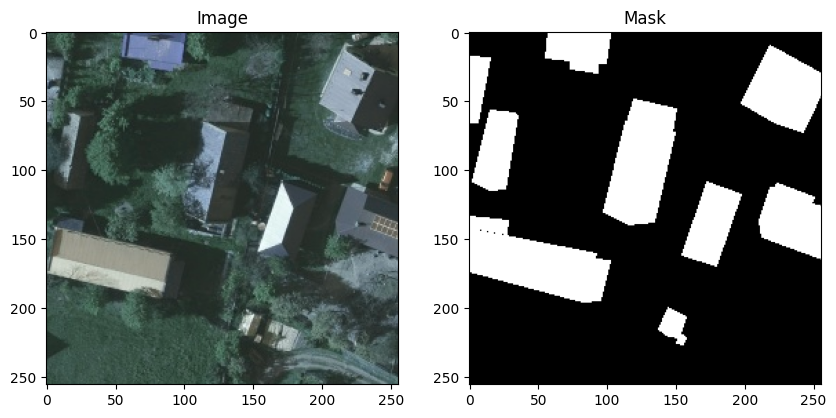

In [8]:
# checking
num_images = len(img_list)
num_masks = len(mask_list)
img_num = random.randint(0, num_images-1)
print(f'Inspect 1 patch image mask pair out of {num_images}')
print(train_img_dir+"images/"+img_list[img_num])
print(train_mask_dir+"masks/"+mask_list[img_num])
img_for_plot = cv2.imread(train_img_dir+"images/"+img_list[img_num], 1)
mask_for_plot = cv2.imread(train_mask_dir+"masks/"+mask_list[img_num], 0)

plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [9]:
print('Max value: ', np.amax(mask_for_plot))
print('Image shape: ', mask_for_plot.shape)
print('Pixels in (256,256) img with value 1 :',np.sum(mask_for_plot==1.0))
print('Pixels in (256,256) img with value 0 :',np.sum(mask_for_plot==0.0))
print('Pixels in (256,256) img with value between 0 and 1 :',np.sum(mask_for_plot>0.0)-np.sum(mask_for_plot==1.0))

Max value:  1
Image shape:  (256, 256)
Pixels in (256,256) img with value 1 : 16131
Pixels in (256,256) img with value 0 : 49405
Pixels in (256,256) img with value between 0 and 1 : 0


In [10]:
X = []
for file in img_list:
    img = cv2.imread(train_img_dir+"images/"+file, 1)
    img=img/255.0
    X.append(img)
Y=[]
for file in mask_list:
    mask =cv2.imread(train_mask_dir+"masks/"+file, 0)
    mask=mask/1.0
    Y.append(mask)
print(len(X), len(Y))
# converting to numpy array
X = np.asarray(X)
print(X.shape)
# convert masks to categorical (one hot encoded) data
Y=np.asarray(Y)
# till now, the masks are integer encoded
print(Y.shape)

1195 1195
(1195, 256, 256, 3)
(1195, 256, 256)


In [11]:
X_test = []
for file in val_img_list:
    img = cv2.imread(val_img_dir+"images/"+file, 1)
    img=img/255.0
    X_test.append(img)
Y_test =[]
for file in val_mask_list:
    mask =cv2.imread(val_mask_dir+"masks/"+file, 0)
    mask=mask/1.0
    Y_test.append(mask)
print(len(X_test), len(Y_test))
# converting to numpy array
X_test = np.asarray(X_test)
print(X_test.shape)
# convert masks to categorical (one hot encoded) data
Y_test=np.asarray(Y_test)
# till now, the masks are integer encoded
print(Y_test.shape)

299 299
(299, 256, 256, 3)
(299, 256, 256)


In [12]:
Y = np.expand_dims(Y, axis = 3)
Y_test = np.expand_dims(Y_test, axis = 3)

In [13]:
Y_test.shape

(299, 256, 256, 1)

In [14]:
from keras import backend as K
from keras import Input
from keras.layers import Lambda, Dropout, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.models import Model

# Mean IOU
def jacard_coef(y_true, y_pred):
    y_true_f=K.flatten(y_true)
    y_pred_f=K.flatten(y_pred)
    intersection=K.sum(y_true_f*y_pred_f)
    return (intersection*1.0)/(K.sum(y_true_f)+K.sum(y_pred_f)-(intersection*1.0))

def jacard_loss(y_true, y_pred):
    return 1-jacard_coef(y_true, y_pred)

IMG_WIDTH=256
IMG_HEIGHT=256
IMG_CHANNELS=3

# multi-class semantic segmentation model (0 and 1, so binary class semantic segmentation)
def unet_model(n_classes):
    """ Contraction path, encoding """
    inputs=Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    # the layers take floating point values. So we have to convert the integers of the pixel values to floating point
    # so we divide all image by 255
    # this is lambda function over the layer
    # inputs=Lambda(lambda x:x/255)(inputs)
    # 64 feature dimensions, kernal size, 
    # he_normal is one kind of provision of starting weights of the neural network. In the process of iteration, the weights get better.
    # this is truncated around 0, and follows gaussian distribution.
    # same padding meanss output image dimensions are same as input image
    # we apply all the conv1 on the inputs layer
    conv1=Conv2D(32,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(inputs)
    # dropping out 10% of the nodes
    conv1=Dropout(0.2)(conv1)
    conv1=Conv2D(32,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(conv1)
    
    # pool size=(2,2)
    conv2=MaxPooling2D((2,2))(conv1)
    conv2=Conv2D(64,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(conv2)
    conv2=Dropout(0.2)(conv2)
    conv2=Conv2D(64,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(conv2)
    
    conv3=MaxPooling2D((2,2))(conv2)
    conv3=Conv2D(128,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(conv3)
    conv3=Dropout(0.2)(conv3)
    conv3=Conv2D(128,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(conv3)
    
    conv4=MaxPooling2D((2,2))(conv3)
    conv4=Conv2D(256,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(conv4)
    conv4=Dropout(0.2)(conv4)
    conv4=Conv2D(256,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(conv4)
    
    conv5=MaxPooling2D((2,2))(conv4)
    conv5=Conv2D(512,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(conv5)
    conv5=Dropout(0.2)(conv5)
    conv5=Conv2D(512,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(conv5)

    """ Expansion path, decoding """
    upconv6=Conv2DTranspose(256,(2,2), strides=(2,2), padding="same")(conv5)
    upconv6=concatenate([upconv6, conv4])
    conv6=Conv2D(256,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(upconv6)
    conv6=Dropout(0.2)(conv6)
    conv6=Conv2D(256,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(conv6)

    upconv7=Conv2DTranspose(128,(2,2), strides=(2,2), padding="same")(conv6)
    upconv7=concatenate([upconv7, conv3])
    conv7=Conv2D(128,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(upconv7)
    conv7=Dropout(0.2)(conv7)
    conv7=Conv2D(128,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(conv7)

    upconv8=Conv2DTranspose(64,(2,2), strides=(2,2), padding="same")(conv7)
    upconv8=concatenate([upconv8, conv2])
    conv8=Conv2D(64,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(upconv8)
    conv8=Dropout(0.2)(conv8)
    conv8=Conv2D(64,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(conv8)

    upconv9=Conv2DTranspose(32,(2,2), strides=(2,2), padding="same")(conv8)
    upconv9=concatenate([upconv9, conv1])
    conv9=Conv2D(32,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(upconv9)
    conv9=Dropout(0.2)(conv9)
    conv9=Conv2D(32,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(conv9)
    
    conv9=Conv2D(16,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(conv9)
    outputs=Conv2D(n_classes,(1,1), activation="sigmoid", padding="same")(conv9)


    model=Model(inputs=[inputs], outputs=[outputs])

    return model

In [15]:
import keras
from keras.optimizers import Adam
model = unet_model(n_classes)
# optimizer includes the backpropagation algorithms to train the model.
# binary cross entropy is used for binary classification of true or not true situations in segmentaiton.
# optimizer tries to minimize the loss function.
# jacard_coef determined "Intersection Over Union" score
'''
loss=[
        jacard_loss,
        'binary_crossentropy'
    ],
    loss_weights=[1,1],
  metrics=[
        "accuracy", 
        jacard_coef
    ]
'''
model.compile(
    optimizer=Adam(learning_rate = 1e-3), loss=jacard_loss, 
    metrics=['accuracy',jacard_coef]
)

Metal device set to: Apple M1


2023-03-31 20:10:43.085918: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-31 20:10:43.086388: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [16]:
print(model.input_shape, model.output_shape)

(None, 256, 256, 3) (None, 256, 256, 1)


In [17]:
# to avoid overfitting of model
earlystopping = EarlyStopping(
    monitor="val_loss", 
    mode="min", patience=3, 
    restore_best_weights=True
)

In [18]:
# make a new folder to save model
try:
    os.makedirs(root_dir+"models")
except:
    print("Directory already available, so not created")

In [19]:
history = model.fit(
    X,Y,
    steps_per_epoch=steps_per_epoch, 
    epochs=20, 
    verbose=1,
    callbacks=[earlystopping],
    validation_data=(X_test, Y_test),
    validation_steps=val_steps_per_epoch
)

Epoch 1/20


2023-03-31 20:10:47.518116: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-31 20:10:48.637542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


74/74 [==============================] - ETA: 0s - loss: 0.8180 - accuracy: 0.1913 - jacard_coef: 0.1830

2023-03-31 20:12:44.587882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


74/74 [==============================] - 125s 2s/step - loss: 0.8180 - accuracy: 0.1913 - jacard_coef: 0.1830 - val_loss: 0.8092 - val_accuracy: 0.1908 - val_jacard_coef: 0.1913
Epoch 2/20
74/74 [==============================] - 138s 2s/step - loss: 0.8173 - accuracy: 0.1826 - jacard_coef: 0.1825 - val_loss: 0.8092 - val_accuracy: 0.1908 - val_jacard_coef: 0.1913
Epoch 3/20
74/74 [==============================] - 126s 2s/step - loss: 0.8173 - accuracy: 0.1826 - jacard_coef: 0.1827 - val_loss: 0.8092 - val_accuracy: 0.1908 - val_jacard_coef: 0.1913
Epoch 4/20
74/74 [==============================] - 131s 2s/step - loss: 0.8176 - accuracy: 0.1822 - jacard_coef: 0.1823 - val_loss: 0.8092 - val_accuracy: 0.1908 - val_jacard_coef: 0.1913


In [21]:
model.save('model_colab_27th_Feb_1.h5')

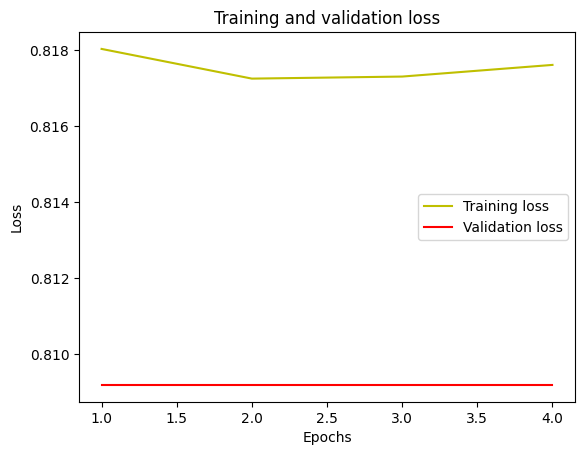

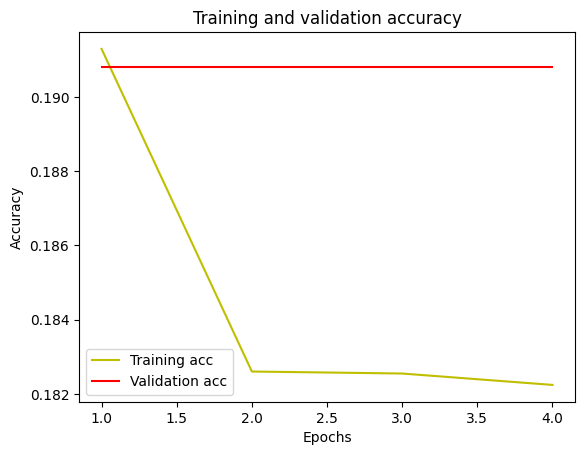

In [22]:

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
y_pred=model.predict(X_test)

2023-03-31 21:31:07.779575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 16s 1s/step


In [27]:
y_pred_thresh =y_pred>0.5

In [28]:
y_pred.shape

(299, 256, 256, 1)

In [29]:
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresh, Y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.095403664


In [30]:
# IOU for individual class
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
print("\n")
class0_IOU = values[0,0]/(values[0,0]+values[0,1])
class1_IOU = values[1,1]/(values[1,0]+values[1,1])
print("Unlabelled IOU: ", class0_IOU)
print("Buildings IOU: ", class1_IOU)

[[       0.        0.]
 [15856344.  3738920.]]


Unlabelled IOU:  nan
Buildings IOU:  0.19080733


/var/folders/l1/rp1rrpyx24d84x0k_6p7pwgw0000gn/T/ipykernel_3718/2880831525.py:5: RuntimeWarning: invalid value encountered in scalar divide
  class0_IOU = values[0,0]/(values[0,0]+values[0,1])


/var/folders/l1/rp1rrpyx24d84x0k_6p7pwgw0000gn/T/ipykernel_3718/1238363827.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


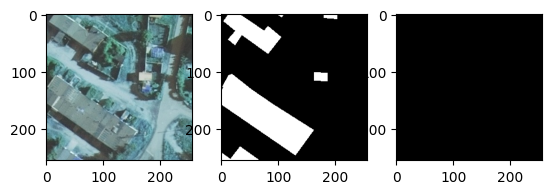

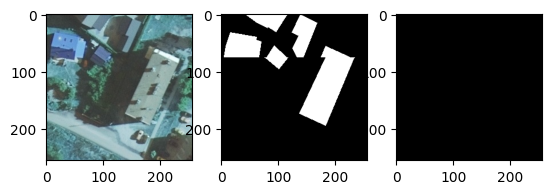

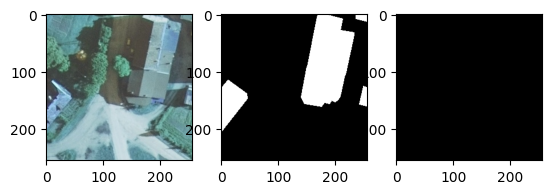

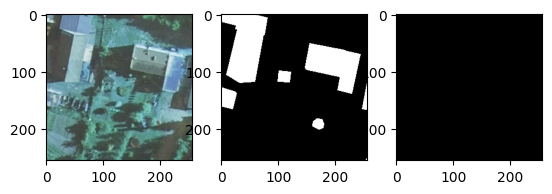

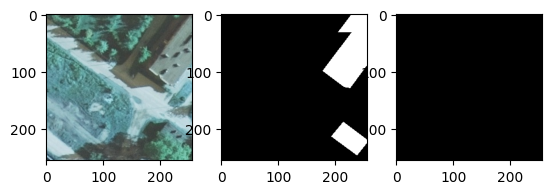

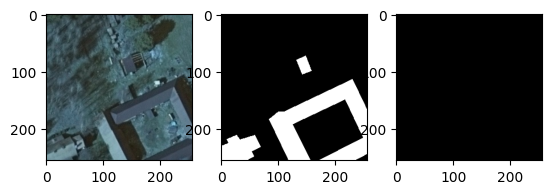

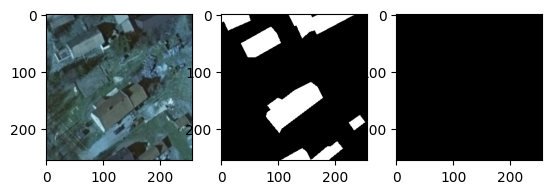

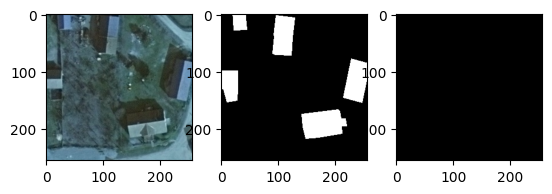

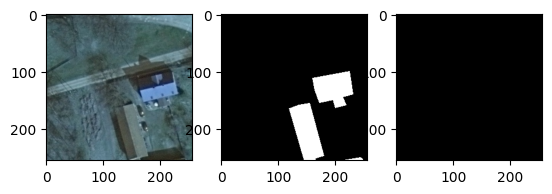

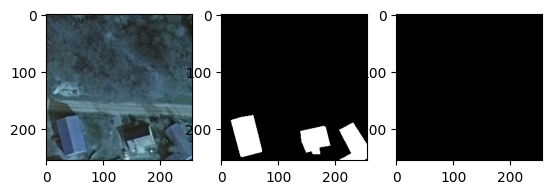

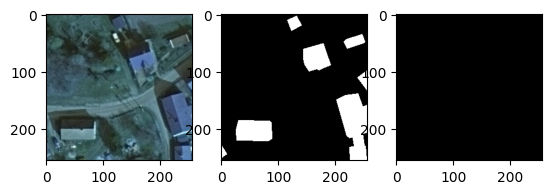

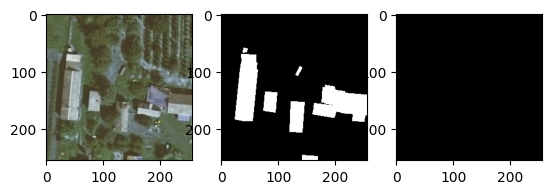

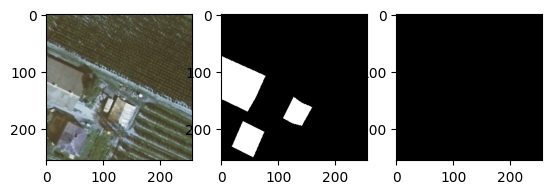

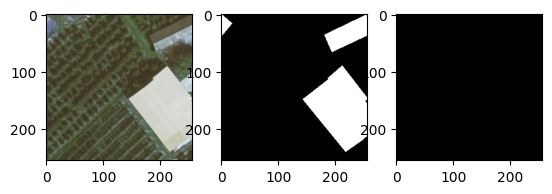

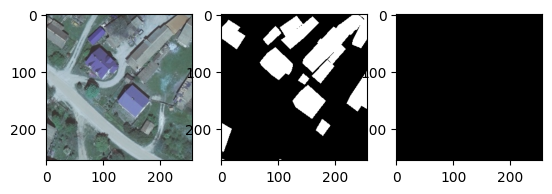

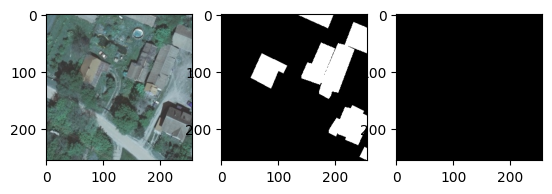

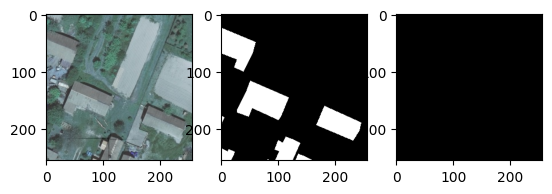

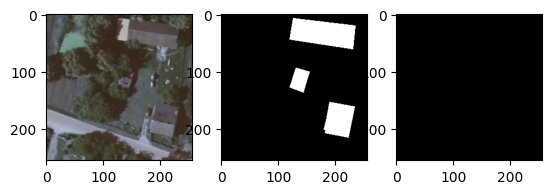

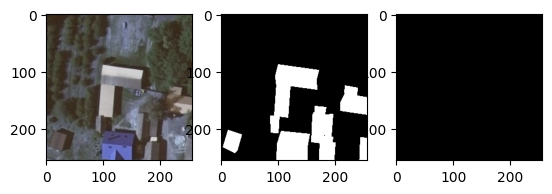

In [31]:
for i in range(11,30):
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow(X_test[i])
    ax[1].imshow(Y_test[i], cmap="gray")
    ax[2].imshow(y_pred_thresh[i],  cmap="gray")
    fig.show()

In [32]:
model=load_model("landcover.ai.v1/256_patches/models/model_colab_27th_Feb_1.h5",)
score = model.evaluate(
    X_test,Y_test, 
    verbose=1,
    steps=val_steps_per_epoch
)
print(score[1])

2023-04-01 00:16:35.338934: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


18/18 [==============================] - 20s 1s/step - loss: 0.1876 - accuracy: 0.9237
0.9236593246459961
